In [33]:
# For neural net
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

# General
import numpy as np
import random
import math
import time
from prettytable import PrettyTable
from tqdm import tqdm


# For text
import re
import string

In [2]:
def create_joke_data(jokes : list, block_size : int=2, special_character : str='.'):
    """
    Takes words list and breaks into training samples based on the desired model-type. For example,
    a bigram model where n=2 or a trigram model where n=3. 
    Returns words (the vocabulary of the model), xs, and ys (inputs and labels).
    """
    # Create list of all words used in the jokes
    words = set(' '.join([j for j in jokes]).split(' '))
    words = [w for w in words if w != ""] ##remove empty string
    # Init dicts
    itow = {i+1 : w for i, w in enumerate(sorted(words))}
    itow[0] = special_character
    wtoi = {w : i for i, w in itow.items()}
    n = block_size + 1

    # Create samples
    X, Y = [], []
    for j in jokes:
        context = [0] * block_size
        word_bag = j.split(' ') + [special_character]  ##add special end characters
        word_bag = [w for w in word_bag if w != ""] ##remove any blank strings that get created
        for w in word_bag:
            ix = wtoi[w]
            X.append(context)
            Y.append(ix)
            # print([itow[c] for c in context], [itow[ix]])

            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
        
    n_samples = X.shape[0]
    print(f"{ n_samples = }")

    
    return words, X, Y


In [3]:

def split_samples(inputs, labels, frac=0.8, seed=123):
    """Split xs and ys (inputs and labels) into train and test sets"""
    
    assert len(inputs)==len(labels), f"{len(inputs) = } which does not match {len(labels) = }"
    # generate a list of indices to exclude. Turn in into a set for O(1) lookup time
    random.seed(seed)
    indx = list(set(random.sample(list(range(len(inputs))), int(frac*len(inputs)))))

    x_mask = torch.zeros((len(inputs)), dtype=torch.bool) #False
    x_mask[indx] = True

    y_mask = torch.zeros((len(inputs)), dtype=torch.bool) #False
    y_mask[indx] = True

    train_x = inputs[x_mask]
    train_y = labels[y_mask]

    test_x = inputs[~x_mask]
    test_y = labels[~y_mask]

    return train_x, train_y, test_x, test_y

In [4]:
class JokeGramMLP:

    def __init__(self, words : list, block_size : int, special_character : str):
        """
        An instance of an MLP where 'block_size' defines the number of characters used 
        to predict the next character (the block size or context).
        """
        self.n_inputs = block_size ##the number of inputs (ie, excluding the label)
        self.special_char = special_character
        # Init dicts
        self.itow = {i+1 : w for i, w in enumerate(sorted(words))}
        self.itow[0] = special_character
        self.wtoi = {w : i for i, w in self.itow.items()}

        self.n_outputs = int(len(self.itow))
        
         
    def initialize_weights(self,
                           embedding_dimensions=2,
                           hidden_layer_neurons=100, 
                           generator=None):
        "Randomly initialize the model's weights."
        self.hl_neurons = hidden_layer_neurons
        self.emb_dim = embedding_dimensions

        # INITALIZE NETWORK WEIGHTS
        n_inputs = self.n_inputs          ##number of inputs per sample (the block size)
        words = self.n_outputs            ##number of words in vocab
        emb_dim = embedding_dimensions    ##dimensions of embedding space
        hl_neurons = hidden_layer_neurons ##number of neurons in hidden layer


        self.C = torch.randn((words, emb_dim), generator=generator, requires_grad=True)

        # self.W1 = torch.randn((emb_dim*n_inputs, hl_neurons), generator=generator, requires_grad=True)
        self.W1 = self._xavier_init(emb_dim*n_inputs, hl_neurons, generator, requires_grad=True)
        self.b1 = torch.zeros(hl_neurons, requires_grad=True)

        # self.W2 = torch.randn((hl_neurons, words), generator=generator, requires_grad=True)
        self.W2 = self._xavier_init(hl_neurons, words, generator, requires_grad=True)
        self.b2 = torch.zeros(words, requires_grad=True)

        self.parameters = [self.C, self.W1, self.b1, self.W2, self.b2]
        for p in self.parameters:
            p.requires_grad=True
        print(f"Model params = { sum(p.nelement() for p in self.parameters) }")

    def _xavier_init(self, n_inputs, n_neurons, generator=None, requires_grad=False):
        """My implementation of xavier-normal weight initialization for tanh layers"""
        with torch.no_grad():
            lower, upper = -(1.0 / math.sqrt(n_inputs)), (1.0 / math.sqrt(n_inputs))
            W = lower + torch.rand((n_inputs, n_neurons), generator=generator) * (upper - lower)
        W.requires_grad = requires_grad
        return W


    def forward_pass(self, xs, ys=None, regularization=0):
        "Perform a forward pass of the inputs (xs) through the network. If ys are provided, loss will be evaluated."
        # forward pass
        n_samples = xs.shape[0]
        n_inputs = self.n_inputs
        hl_neurons = self.hl_neurons
        emb_dim = self.emb_dim

        parameters = self.parameters

        assert n_inputs == xs.shape[1], f"n_inputs ({n_inputs}) does not match the xs.shape[1]"

        # Forward pass
        emb = self.C[xs]
        h = torch.tanh( emb.view(-1, n_inputs*emb_dim) @ self.W1 + self.b1 )   
        logits = h @ self.W2 + self.b2
        # predicted probabilities
        probs = F.softmax(logits, dim=1)

        # loss
        loss = None
        if ys is not None: #eval loss
            loss = F.cross_entropy(logits, ys)
            if regularization > 0.0:       
                # R is a weight decay penalty applied only to the weights of the neural network and to the C matrix, not to the biases - Bengio 1142
                for w in [self.C, self.W1, self.W2]:
                    loss += regularization*(w**2).mean()
            self.loss = loss
        
        return probs, loss
                

    def backprop_update(self, lr=0.1):
        "Gradient descent - backpropogate the network and apply a fraction of the gradients to the current weights."
        # backward pass
        for p in self.parameters:
            p.grad = None ##zero the gradient

        self.loss.backward() ##backprop

        # update params
        for p in self.parameters:
            p.data += -lr * p.grad ##learning rate


    def generate_jokes(self, n_words, start_words: str = "", min_length=0, generator=None):
        """
        Generates n_words word examples by passing n-1 random characters into the model, performing a forward pass,
        and probabilistically choosing a character using the model's predicted probability distribution.
        Pass n-2 start_chrs to specify the starting characters of the word generation process (first character is always '.').
        Specify a minimum word length min_length to generate words at least that long.
        """
        itow = self.itow
        wtoi = self.wtoi
        n_inputs = self.n_inputs
        out_jokes = []

        for _ in range(n_words):
            joke = self.special_char #start with special character
            context = [0] * n_inputs 
            
            assert len(start_words.split()) <= n_inputs, f"Number of start words ({len(start_words.split())}) should be {n_inputs} or less."
            for w in start_words.split():
                assert w in wtoi, f"Start word '{w}' cannot be used since it is not in the list of training words."
                joke += " " + w.lower()
                context[1:] + [wtoi[w.lower()]]

            while True:
                # forward pass
                probs, loss = self.forward_pass(
                    torch.tensor([context]) #.reshape(1, n_inputs)
                    )
                # Get word
                word_ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=generator).item()
                # determine how to proceed
                if (word_ix==0) & (len(joke.split())-1 <= min_length): ##if the ix is 0 but the joke is too short, resample (-1 due to starting .)
                    pass
                elif (word_ix==0) & (len(joke.split())-1 > min_length): ##if the ix is 0 and joke is long enough, end joke and break joke creation
                    joke += " " + itow[word_ix] ##ends with special char
                    break
                else:                                   ##otherwise, add to the joke and shift the context for the next forward pass
                    joke += " " + itow[word_ix]
                    ## Shift words to predict the next one
                    context = context[1:] + [word_ix] ##shift and append  
                    
            joke = re.sub(r'(\d)\s+(\d)', r'\1\2', joke) ##concatenate sequential numbers
            out_jokes.append(joke)    
        
        return out_jokes

# Data

In [5]:
# Read in text file - one joke per line
with open('jokes.txt') as f:
    jokes = f.read().splitlines()

In [6]:
N = 5 ## Number of words involved
SPECIAL = '.' ## Special character to use for start/stop/padding

In [7]:
# Create dataset based on N and split into training and development sets
words, X, Y = create_joke_data(jokes, N-1, special_character=SPECIAL)
Xtr, Ytr, Xdev, Ydev = split_samples(X, Y, 0.8, seed=123)

print(f"{len(words) = }")

 n_samples = 29227
len(words) = 4339


# Model Initialization

In [8]:
# Initialize the joke model based on N and provide with list of words in data. Initialize weights based on desired model structure
g = torch.Generator().manual_seed(123)

model = JokeGramMLP(words=words, block_size=N-1, special_character=SPECIAL)
model.initialize_weights(embedding_dimensions=60,
                         hidden_layer_neurons=100, 
                         generator=g)

## See Bengio 1149 for their model specifications

Model params = 722840


## Hyperparameter tuning

In [10]:
# LR Random Search (randomly sample from within range and try each lr)
lre = [random.uniform(-3, 0) for _ in range(1000)] #torch.linspace(-3, 0, 1000)
lrs = [10**lr for lr in lre] #10**lre
lrs = sorted(lrs, reverse=True)

lr_losses = [] ##save lrs to this list (dont overwrite)

# plt.plot(lrs, lr_losses) #[math.log10(l) for l in lr_losses])
# plt.title("LR Search - 0.1 looks alright")
# plt.show()

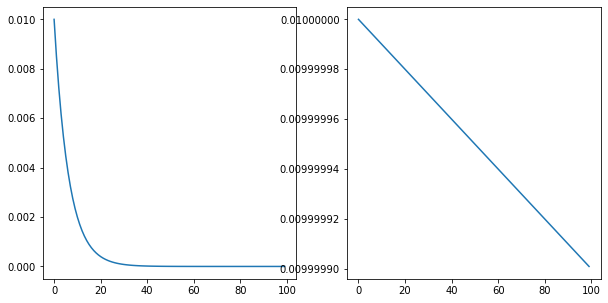

In [32]:
# LR schedule
"""
For training the neural networks, the initial learning rate was set to εo = 10e-3 (after a few trials
with a tiny data set), and gradually decreased according to the following schedule: εt = εo / 1+rt where t 
represents the number of parameter updates done and r is a decrease factor that was heuristically
chosen to be r = 10e-8.
 - Bengio 1147
"""
lr = 10e-3
decay = 10e-8
epochs = 100
exp_decay, ben_decay = [], []
for ep in range(epochs):
    lr_exp = lr * decay ** (ep / epochs) ##exponential decay
    lr_lin = lr / (1 + decay*ep) ##Bengio's decay
    exp_decay.append(lr_exp)
    ben_decay.append(lr_lin)

fig, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].plot(exp_decay)
ax[1].plot(ben_decay)
ax[1].ticklabel_format(useOffset=False)
plt.show()

# Training

In [18]:
# Initialzie lists to store metrics
losses, val_losses = [],[]

In [60]:
# TRAIN
epochs = 100
batch_size = 64
print(f"steps per epoch = {Xtr.shape[0] // batch_size}")

for ep in range(epochs):
    """ MINNIBATCHING """
    ## batch_ix = torch.randint(0, Xtr.shape[0], (batch_size, )) ##n_samples randints between 0 and length of data
    permutation = torch.randperm(Xtr.shape[0])  ##permutate randomly through ALL training data 
    batch_losses = []
    
    strt = time.time()
    loop = tqdm(range(0, Xtr.shape[0], batch_size), desc="Batch progress: ", leave=False)
    for k in loop:
        batch_ix = permutation[k : k+batch_size]

        # forward pass
        probs, loss = model.forward_pass(Xtr[batch_ix], Ytr[batch_ix], regularization=0.01)
        batch_losses.append(loss.item())
        loop.set_postfix(loss = loss.item())
        
        # backward pass + update
        lr0 = 10e-3 #lrs[k]
        decay = 10e-2
        ## bengio's decay
        lr_new = lr0 / (1 + decay*ep)

        model.backprop_update(lr=lr_new)
    stp = time.time()

    """ EVALUATION """
    with torch.no_grad():
        _, val_loss = model.forward_pass(Xdev, Ydev)
        

    """ TRACKING """
    # update epoch-level loss stats
    losses.append(sum(batch_losses) / len(batch_losses)) #mean batch loss
    val_losses.append(val_loss.item())
    #lr_losses.append(loss.item())

    # log updates & track stats
    if (ep in range(0, epochs, math.ceil(epochs*0.10))) or (ep==epochs-1):
        print(f"Epoch {ep}/{epochs}:", end=" ")
        print(f"train_loss={round(sum(batch_losses) / len(batch_losses), 5)} |", end=" ")
        print(f"dev_loss={round(val_loss.item(), 5)} |", end=" ")
        print(f"lr={round(lr_new, 5)} |", end=" ")
        print(f"time={round(stp-strt, 3)}s")


steps per epoch = 365


Epoch 0: train_loss=4.39434 | dev_loss=5.84309 | lr=0.01 | time=9.416s


Epoch 10: train_loss=4.33609 | dev_loss=5.85466 | lr=0.005 | time=6.941s


Epoch 20: train_loss=4.30278 | dev_loss=5.86241 | lr=0.0033333333333333335 | time=6.605s


Epoch 30: train_loss=4.27873 | dev_loss=5.86786 | lr=0.0025 | time=6.634s


Epoch 40: train_loss=4.26333 | dev_loss=5.87222 | lr=0.002 | time=5.594s


Epoch 50: train_loss=4.25092 | dev_loss=5.87599 | lr=0.0016666666666666668 | time=5.78s


Epoch 60: train_loss=4.24063 | dev_loss=5.87913 | lr=0.0014285714285714286 | time=5.956s


Epoch 70: train_loss=4.23086 | dev_loss=5.88197 | lr=0.00125 | time=7.556s


Epoch 80: train_loss=4.22335 | dev_loss=5.88439 | lr=0.0011111111111111111 | time=6.594s


Epoch 90: train_loss=4.21457 | dev_loss=5.88662 | lr=0.001 | time=6.239s


Epoch 99: train_loss=4.20863 | dev_loss=5.8885 | lr=0.0009174311926605504 | time=6.729s


In [61]:
# Evaluate on full training data (not batched)
with torch.no_grad():
    _, loss = model.forward_pass(Xtr, Ytr)

print("Full training loss = ", loss.item() )

Full training loss =  4.195002555847168


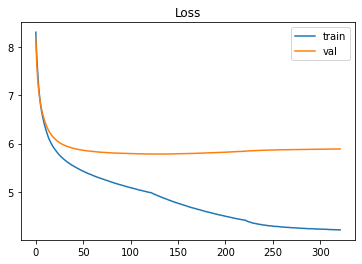

In [62]:
plt.plot(losses, label="train")
plt.plot(val_losses, label="val")
plt.legend()
plt.title("Loss")
plt.show()

In [65]:
model.generate_jokes(5, start_words="")

['. try someone seriously old to see has garden 2 down that bulb teacher her replied the do all it was than doubt .',
 '. how come presidential every tomorrow marbles left even into it .',
 ". marriage was got i'm hotter idea wonder .",
 '. from golden if there was attending time it of sex 2 .',
 ". just when you said message line pooper to married are filmed stubasaurus of enjoys me trod dawn sugar up ? ? eclipse luke go you knee for shaved will you everyone you are forgotten are them years wants will when didn't a remote light ? ? 1 pope to say science too on ."]

In [49]:
[j for j in jokes if " scotsman" in j]

['the englishman and the scotsman both walk into a bar the irishman ducks under it',
 "an englishman a scotsman and a rabbi walk into a bar the rabbi stops and says i think i'm in the wrong joke",
 'an englishman an irishman and a scotsman walk into a bar the bartender turns to them takes one look and says what is this some kind of joke ?']